# PPO-CLIP

PPO-CLIP objective is
$$
\arg \max_\theta\mathbb{E}_{a,s\sim \pi_{old}}[\frac {\pi_\theta(a|s)}{\pi_{old}(a|s)} * \hat{A}]=\arg \max_\theta\mathbb{E}_{a,s\sim \pi_{old}}[r_\theta(a|s) * \hat{A}]
$$

We want to reduce variance of policy gradient as large gradients might cause diversion of the policy.
This can be done by clipping the gradient. Let's make sure that it always falls within a small range:

$$
(1-\epsilon)*\hat{A} \leq r_\theta*\hat{A} \leq (1+\epsilon)*\hat{A}
$$

To support both positive and negative advantage values, we can rewrite the above condition into the following differentiable function:

$$
\mathcal{L}^{CLIP}=\mathbb{E}_{\pi_{old}}[min(r_\theta*\hat{A}, clip(r_\theta, 1-\epsilon, 1+\epsilon)*\hat{A})]
$$

Advantage can be calculated by either MC or TD(0) estimates. With TD(0) we'll need a value function estimate.
$$
\hat{A} = R_{t+1} + \gamma*v(s_{t+1}) - v(s_t)
$$

Value update is constructed from a sample of Bellman's expectation equation. We use MSE loss to push value estimate towards TD(0) bootstrapped targets.

$$
\mathcal{L}^V= ([[R_{t+1} + v(s_t+1)]] - v(s_t))^2
$$

Additional term is an entropy bonus $S$, which promotes more uniform distributions:

$$
S = \mathbb{E}[-H(\pi_\theta(s))]
$$

Final loss term takes the form:
$$
\mathcal{L}^{CLIP+V+S}=\mathcal{L}^{CLIP}+c_1*\mathcal{L}^{V}+c_2*S
$$

## Links
* [Proximal Policy Optimization Algorithms](https://arxiv.org/abs/1707.06347)

In [24]:
import gym
import numpy as np
import torch
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

In [25]:
class DiscretePolicyModel(torch.nn.Module):
    def __init__(self, state_size, actions_size, hidden_size):
        super().__init__()
        self.policy_nn = torch.nn.Sequential(
            torch.nn.Linear(state_size, hidden_size),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_size, actions_size),
            torch.nn.Softmax(dim=0)
        )

    def forward(self, state):
        return torch.distributions.Categorical(self.policy_nn(state))

    def act(self, state):
        dist = self.forward(state)
        action = dist.sample()
        return action.numpy(), dist.log_prob(action), dist


class ContinuousPolicyModel(torch.nn.Module):
    def __init__(self, state_size, actions_size, hidden_size):
        super().__init__()
        self.mu = torch.nn.Sequential(
            torch.nn.Linear(state_size, hidden_size),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_size, actions_size),
        )
        self.log_std = torch.nn.Parameter(-0.5 * torch.ones(actions_size, dtype=torch.float32))

    def forward(self, state):
        mus = self.mu(state)
        dist = torch.distributions.Normal(mus, torch.exp(self.log_std))
        return dist

    def act(self, state):
        dist = self.forward(state)
        action = dist.sample()
        return action.numpy(), dist.log_prob(action), dist


class ValueModel(torch.nn.Module):
    def __init__(self, state_size, hidden_size):
        super().__init__()
        self.value_nn = torch.nn.Sequential(
            torch.nn.Linear(state_size, hidden_size),
            torch.nn.SiLU(),
            torch.nn.Linear(hidden_size, 1)
        )

    def forward(self, state):
        return self.value_nn(state)[0]


DiscretePolicyModel(2, 2, 4).act(torch.tensor([1, 2.])), ContinuousPolicyModel(2, 2, 4).act(
    torch.tensor([1, 2.])), ValueModel(2, 4)(torch.tensor([1, 2.]))

((array(1),
  tensor(-0.9094, grad_fn=<SqueezeBackward1>),
  Categorical(probs: torch.Size([2]), logits: torch.Size([2]))),
 (array([ 1.3670285 , -0.33310464], dtype=float32),
  tensor([-1.7339, -0.4299], grad_fn=<SubBackward0>),
  Normal(loc: torch.Size([2]), scale: torch.Size([2]))),
 tensor(-0.3594, grad_fn=<SelectBackward0>))

In [30]:
def train_ppo(env_name,
              episodes=3000,
              gamma=0.98,
              eps=0.1,
              entropy_loss_weight=0.01,
              hidden_size=256,
              early_stopping_reward=300,
              td_n=0,
              normalize_advantage=True):
    with gym.make(env_name) as env:
        if type(env.action_space) is gym.spaces.Discrete:
            policy_model = DiscretePolicyModel(env.observation_space.shape[0], env.action_space.n, hidden_size)
        else:
            policy_model = ContinuousPolicyModel(env.observation_space.shape[0], env.action_space.shape[0], hidden_size)
        value_model = ValueModel(env.observation_space.shape[0], hidden_size)
        policy_model.train()
        value_model.train()

        optim1 = torch.optim.Adam(policy_model.parameters())
        optim2 = torch.optim.Adam(value_model.parameters())

        progress = tqdm(range(episodes))
        episode_lengths = []
        losses = []
        total_rewards = []
        rewards = []
        values = []
        policy_entropies = []
        for episode in progress:
            state = env.reset()
            trace = []
            total_reward = 0
            for step in range(1000):
                action, action_logprob, action_dist = policy_model.act(torch.as_tensor(state))
                value = value_model(torch.as_tensor(state))
                new_state, reward, done, _ = env.step(action)
                total_reward += reward
                if len(trace) > 0:
                    trace[-1]['new_state_value'] = value.item()

                trace.append({
                    'state': state,
                    'value': value,
                    'action_dist': action_dist,
                    'action_logprob': action_logprob,
                    'action': action,
                    'reward': reward,
                    'new_state': new_state,
                    'done': done
                })
                state = new_state

                if done:
                    trace[-1]['new_state_value'] = 0.

                    episode_lengths.append(step)
                    total_rewards.append(total_reward)

                    # ***************** TRAINING STEP ****************

                    # Calculate n-step returns
                    for i1, t1 in enumerate(trace):
                        r = 0
                        for i2, t2 in enumerate(trace[i1:i1 + td_n + 1]):
                            r += (gamma ** (i2 - i1)) * t2['reward']
                        if i1 + td_n < len(trace):
                            r += gamma ** (td_n + 1) * trace[i1 + td_n]['new_state_value']
                        t1['td_n_return'] = r

                    advantages = []
                    for t in trace:
                        t['advantage'] = (t['reward'] + gamma * t['new_state_value'] - t['value']).item()
                        advantages.append(t['advantage'])
                    if normalize_advantage:
                        advantages = (advantages - np.mean(advantages)) / (np.std(advantages) + 1e-8)

                    # PPO-CLIP policy gradient
                    clip_losses = []
                    for advantage, t in zip(advantages, trace):
                        p_old = np.exp(t['action_logprob'].item())
                        p_new = torch.exp(t['action_logprob'])
                        ratio = p_new / p_old
                        clip_losses.append(
                            torch.min(ratio * advantage, torch.clip(ratio, 1 - eps, 1 + eps) * advantage))
                    clip_losses = -torch.stack(clip_losses).mean()  # negative expected returns for gradient **ascent**

                    # value loss
                    value_losses = []
                    for t in trace:
                        value_loss = (t['td_n_return'] - t['value']) ** 2
                        value_losses.append(value_loss)
                    value_losses = torch.stack(value_losses).mean()

                    # Policy entropy loss
                    entropy_losses = []
                    for t in trace:
                        entropy_losses.append(t['action_dist'].entropy())

                    entropy_losses = -torch.stack(
                        entropy_losses).mean()  #  Maximizing entropy == minimizing negative entropy

                    # Policy update
                    policy_loss = clip_losses + entropy_loss_weight * entropy_losses
                    optim1.zero_grad()
                    policy_loss.backward()
                    optim1.step()

                    # Value update
                    optim2.zero_grad()
                    value_losses.backward()
                    optim2.step()

                    losses.append(policy_loss.item())
                    values.append(np.mean([t['value'].item() for t in trace]))
                    rewards.append(np.mean([t['reward'] for t in trace]))
                    policy_entropies.append(-entropy_losses.item())

                    progress.set_description(
                        f'Episode lengths:{np.mean(episode_lengths[-10:]):04.0f}; total rewards:{np.mean(total_rewards[-10:]):04.0f}; '
                        f'value estimates:{np.mean(values[-10:]):05.1f}; entropy:{np.mean(policy_entropies[-10:]):.04f}')
                    trace = []

                if done:
                    break
            if np.mean(episode_lengths[-10:]) > early_stopping_reward:
                print('Early stopping')
                break

        fig, axs = plt.subplots(4, 1, figsize=(10, 15))
        axs[0].plot(episode_lengths)
        axs[0].set_title('Episode lengths')
        axs[1].plot(losses)
        axs[1].set_title('Loss')
        axs[2].plot(values)
        axs[2].set_title('Value estimates')
        axs[3].plot(policy_entropies)
        axs[3].set_title('Policy entropy')

        return policy_model


def run_policy(policy_model, env_name='CartPole-v1', episodes=1):
    with gym.make(env_name) as env:
        for e in range(episodes):
            state = env.reset()
            done = False
            while not done:
                env.render()
                state, reward, done, _ = env.step(policy_model.act(torch.as_tensor(state))[0])



## CartPole

  0%|          | 0/3000 [00:00<?, ?it/s]

Early stopping


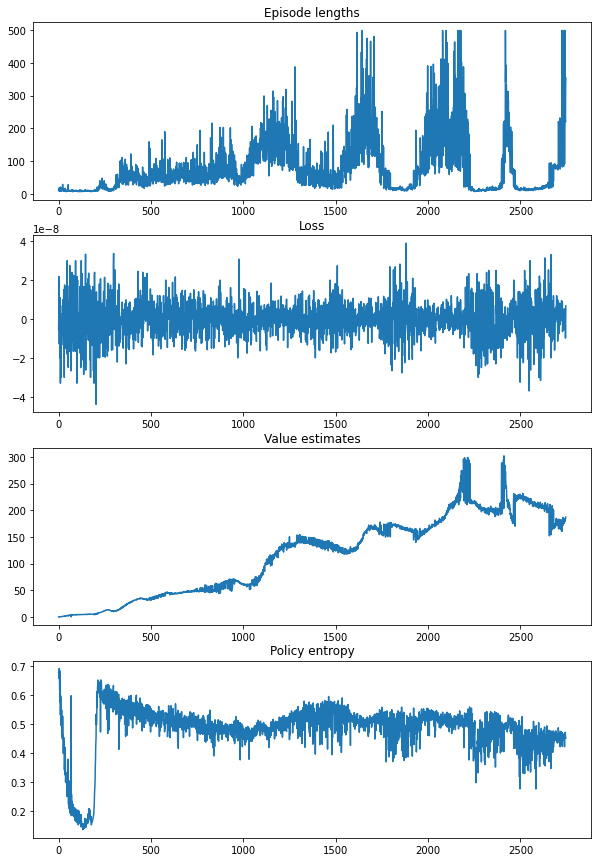

In [28]:
policy_model = train_ppo('CartPole-v1', td_n=3, entropy_loss_weight=0., gamma=0.98, eps=0.1, episodes=3000)

In [31]:
run_policy(policy_model, 'CartPole-v1', episodes=2)

## Pendulum

  0%|          | 0/1000 [00:00<?, ?it/s]

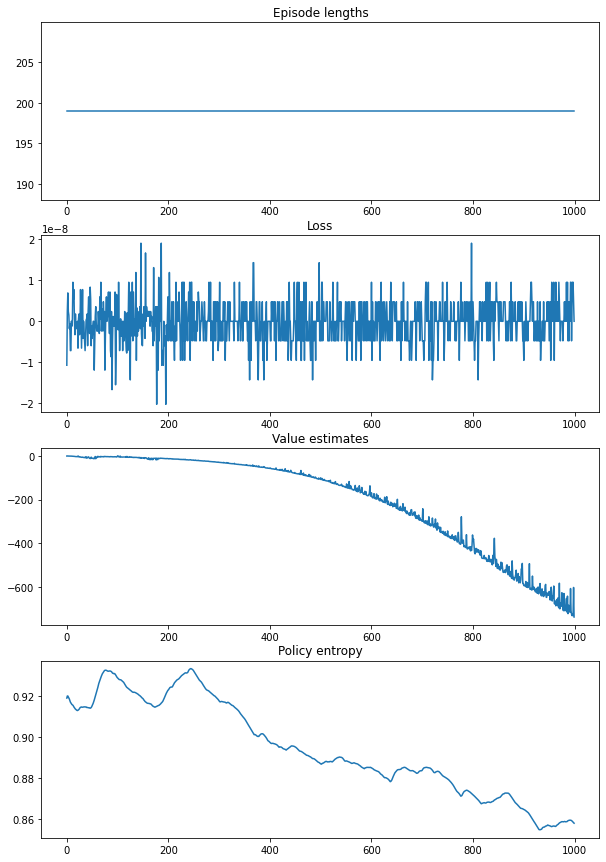

In [32]:
policy_model = train_ppo("Pendulum-v1", eps=0.2, entropy_loss_weight=0., gamma=0.9, episodes=1000, td_n=5)

In [33]:
run_policy(policy_model, 'Pendulum-v1', episodes=2)